In [1]:
!pip install wikipedia-api pandas spacy networkx scipy

In [3]:
import wikipediaapi
import pandas as pds
import concurrent.futures
from tqdm import tqdm
import time

In [4]:
def scrape_wikipedia(name_topic, verbose=True):
   def link_to_wikipedia(link):
       try:
           page = api_wikipedia.page(link)
           if page.exists():
               # cuz 429 error, need delay.
               time.sleep(0.3)
               return {'page': link, 'text': page.text, 'link': page.fullurl, 'categories': list(page.categories.keys())}
       except:
           return None
      
   api_wikipedia = wikipediaapi.Wikipedia(language='en', extract_format=wikipediaapi.ExtractFormat.WIKI)
   name_of_page = api_wikipedia.page(name_topic)
   if not name_of_page.exists():
       print('Page {} is not present'.format(name_of_page))
       return
  
   links_to_page = list(name_of_page.links.keys())
   procceed = tqdm(desc='Scraped links', unit='', total=len(links_to_page)) if verbose else None
   origin = [{'page': name_topic, 'summary': name_of_page.summary, 'text': name_of_page.text, 'link': name_of_page.fullurl, 'categories': list(name_of_page.categories.keys())}]
   
   with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
       links_future = {executor.submit(link_to_wikipedia, link): link for link in links_to_page}
       for future in concurrent.futures.as_completed(links_future):
           info = future.result()
           origin.append(info) if info else None
           procceed.update(1) if verbose else None
   procceed.close() if verbose else None
  
   namespaces = ('Wikipedia', 'Special', 'Talk', 'LyricWiki', 'File', 'MediaWiki',
                 'Template', 'Help', 'User', 'Category talk', 'Portal talk')
   origin: pds = pds.DataFrame(origin)
   origin = origin[(len(origin['text']) > 20)
                     & ~(origin['page'].str.startswith(namespaces, na=True))]
   origin['categories'] = origin.categories.apply(lambda a: [b[9:] for b in a])

   origin['topic'] = name_topic
   print('Scraped pages', len(origin))
  
   return origin, len(origin)

In [5]:
wiki_data, data_size = scrape_wikipedia('COVID')

Scraped links: 100%|██████████| 2360/2360 [35:56<00:00,  1.09/s]

Scraped pages 2106


In [2]:
wiki_data.to_csv('wiki_scraped.csv')

NameError: name 'wiki_data' is not defined

#### 필요한 모듈 import
- 만약 Can't find model 'en_core_web_sm' 오류가 뜨면?
    - python -m spacy download en_core_web_sm

In [12]:
import spacy
import requests
from spacy import displacy
# import en_core_web_sm
 
nlp: spacy = spacy.load('en_core_web_sm')
 
from spacy.tokens import Span
from spacy.matcher import Matcher
 
import matplotlib.pyplot as plot
from tqdm import tqdm
import networkx as ntx
 
%matplotlib inline

In [4]:
data: pds = pds.read_csv('wiki_scraped.csv')
data = data.drop([data.columns[0]], axis=1)
data

,page,summary,text,link,categories,topic
0,COVID,Coronavirus disease 2019 (COVID-19) is a conta...,Coronavirus disease 2019 (COVID-19) is a conta...,https://en.wikipedia.org/wiki/COVID-19,"['All Wikipedia articles in need of updating',...",COVID
1,202-CoV,NaN,202-CoV is a COVID-19 vaccine candidate develo...,https://en.wikipedia.org/wiki/202-CoV,"['All stub articles', 'Articles containing unv...",COVID
2,2020 Russia–Saudi Arabia oil price war,NaN,"On 8 March 2020, Saudi Arabia initiated a pric...",https://en.wikipedia.org/wiki/2020_Russia%E2%8...,"['2020 in Russia', '2020 in Saudi Arabia', '20...",COVID
3,2020 Tablighi Jamaat COVID-19 hotspot in Delhi,NaN,A Tablighi Jamaat religious congregation that ...,https://en.wikipedia.org/wiki/2020_Tablighi_Ja...,"['2020s in Delhi', 'All Wikipedia articles wri...",COVID
4,2020 Tablighi Jamaat COVID-19 hotspot in Malaysia,NaN,A Tablighi Jamaat religious conference that to...,https://en.wikipedia.org/wiki/2020_Tablighi_Ja...,"['2020s in Malaysia', 'Articles with short des...",COVID
...,...,...,...,...,...,...
2101,Category:Wikipedia articles in need of updatin...,NaN,This category combines all Wikipedia articles ...,https://en.wikipedia.org/wiki/Category:Wikiped...,"['CatAutoTOC generates standard Category TOC',...",COVID
2102,Category:Wikipedia articles in need of updatin...,NaN,This category combines all Wikipedia articles ...,https://en.wikipedia.org/wiki/Category:Wikiped...,"['CatAutoTOC generates standard Category TOC',...",COVID
2103,Portal:COVID-19,NaN,NaN,https://en.wikipedia.org/wiki/Portal:COVID-19,"['All portals', 'All portals with triaged subp...",COVID
2104,Portal:Medicine,NaN,NaN,https://en.wikipedia.org/wiki/Portal:Medicine,"['All portals', 'All portals with triaged subp...",COVID


In [5]:
data['text'][10]

'The 2021 Dutch curfew riots (Dutch: avondklokrellen) were a series of riots in the Netherlands that initiated as protests against the government\'s COVID-19 prevention measures and specifically the 21:00–4:30 curfew that was introduced on 23 January 2021. The police have described the riots as the worst in the country since the 1980 coronation riots.\n\nBackground\nThe proposal to introduce a nationwide curfew to curb the spread of the coronavirus disease 2019 (COVID-19) had been put on the table by the Outbreak Management Team (OMT) as early as September 2020, but did not gain the support of the House of Representatives at the time, because of its strong association with World War II.Four months later, however, the measure was deemed necessary as the number of infections was not declining fast enough, despite the fact that the Netherlands had been in a full lockdown since 14 December 2020. Furthermore, the more transmissible B.1.1.7 variant of the virus continued to spread across the

In [6]:
def extract_entities(sents):
   # chunk one
   enti_one: str = ""
   enti_two: str = ""
  
   dep_prev_token: str = "" # dependency tag of previous token in sentence
  
   txt_prev_token: str = "" # previous token in sentence
  
   prefix: str = ""
   modifier: str = ""
  
   for tokn in nlp(sents):
       # chunk two
       ## move to next token if token is punctuation
      
       if tokn.dep_ != "punct":
           #  check if token is compound word or not
           if tokn.dep_ == "compound":
               prefix = tokn.text
               # add the current word to it if the previous word is 'compound’
               if dep_prev_token == "compound":
                   prefix = txt_prev_token + " "+ tokn.text
                  
           # verify if token is modifier or not
           if tokn.dep_.endswith("mod") == True:
               modifier = tokn.text
               # add it to the current word if the previous word is 'compound'
               if dep_prev_token == "compound":
                   modifier = txt_prev_token + " "+ tokn.text
                  
           # chunk3
           if tokn.dep_.find("subj") == True:
               enti_one = modifier +" "+ prefix + " "+ tokn.text
               prefix = ""
               modifier = ""
               dep_prev_token = ""
               txt_prev_token = ""
              
           # chunk4
           if tokn.dep_.find("obj") == True:
               enti_two = modifier +" "+ prefix +" "+ tokn.text
              
           # chunk 5
           # update variable
           dep_prev_token = tokn.dep_
           txt_prev_token = tokn.text
          
   return [enti_one.strip(), enti_two.strip()]

In [16]:
from spacy import displacy

doc = nlp(data['text'][0])
displacy.serve(doc, style="ent")


Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [17]:
print(extract_entities(data['text'][0]))

['social  distancing', 'syndrome assessment clinics']


In [19]:
pairs_of_entities: list = []

for i in tqdm(data['text'][:1000]):
   pairs_of_entities.append(extract_entities(i))

100%|██████████| 1000/1000 [04:54<00:00,  3.40it/s]


In [20]:
def obtain_relation(sent):
  
   doc = nlp(sent)
  
   matcher = Matcher(nlp.vocab)
  
   pattern = [[{'DEP':'ROOT'}],
            [{'DEP':'prep','OP':"?"}],
            [{'DEP':'agent','OP':"?"}],  
            [{'POS':'ADJ','OP':"?"}]] 
  
   matcher.add("matching_1", pattern)
  
   matcher = matcher(doc)
   h = len(matcher) - 1
  
   span = doc[matcher[h][1]:matcher[h][2]]
  
   return (span.text)

In [21]:
print(obtain_relation(data['text'][0]))

syndrome


In [22]:
relations = [obtain_relation(j) for j in data['text'][:1000]]

In [23]:
pds.Series(relations).value_counts()[:50]

in                         149
of                         136
References                 109
at                          62
External                    59
by                          54
on                          41
links                       34
See                         28
for                         26
Notes                       22
Official                    20
from                        18
Retrieved                   10
to                          10
pandemic                     8
website                      6
syndrome                     5
with                         5
during                       5
reading                      4
per                          4
via                          4
Further                      4
Cumulative                   4
PMID                         3
Times                        3
Of                           3
collapsible                  3
Portal                       3
maint                        2
Express                      2
Agency  

In [24]:
# subject extraction
source = [j[0] for j in pairs_of_entities]

#object extraction
target = [k[1] for k in pairs_of_entities]

data_kgf = pds.DataFrame({'source':source, 'target':target, 'edge':relations})

In [25]:
graph = ntx.from_pandas_edgelist(data_kgf, "source", "target",
                         edge_attr=True, create_using=ntx.MultiDiGraph())

/home/chobo/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12491 (\N{KATAKANA LETTER NI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/chobo/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12517 (\N{KATAKANA LETTER SMALL YU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/chobo/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/chobo/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


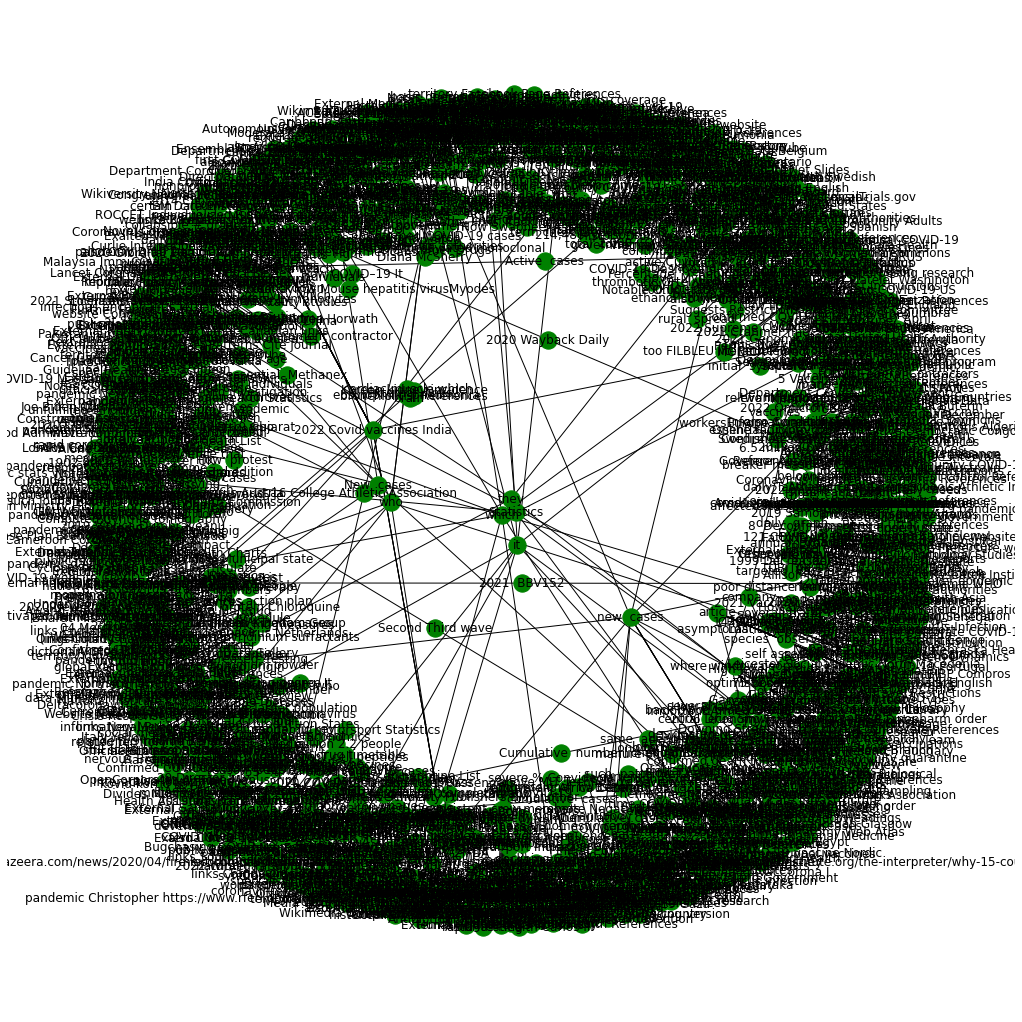

In [26]:
# plotting the network
plot.figure(figsize=(14, 14))
posn = ntx.spring_layout(graph)
ntx.draw(graph, with_labels=True, node_color='green', edge_cmap=plot.cm.Blues, pos = posn)
plot.show()

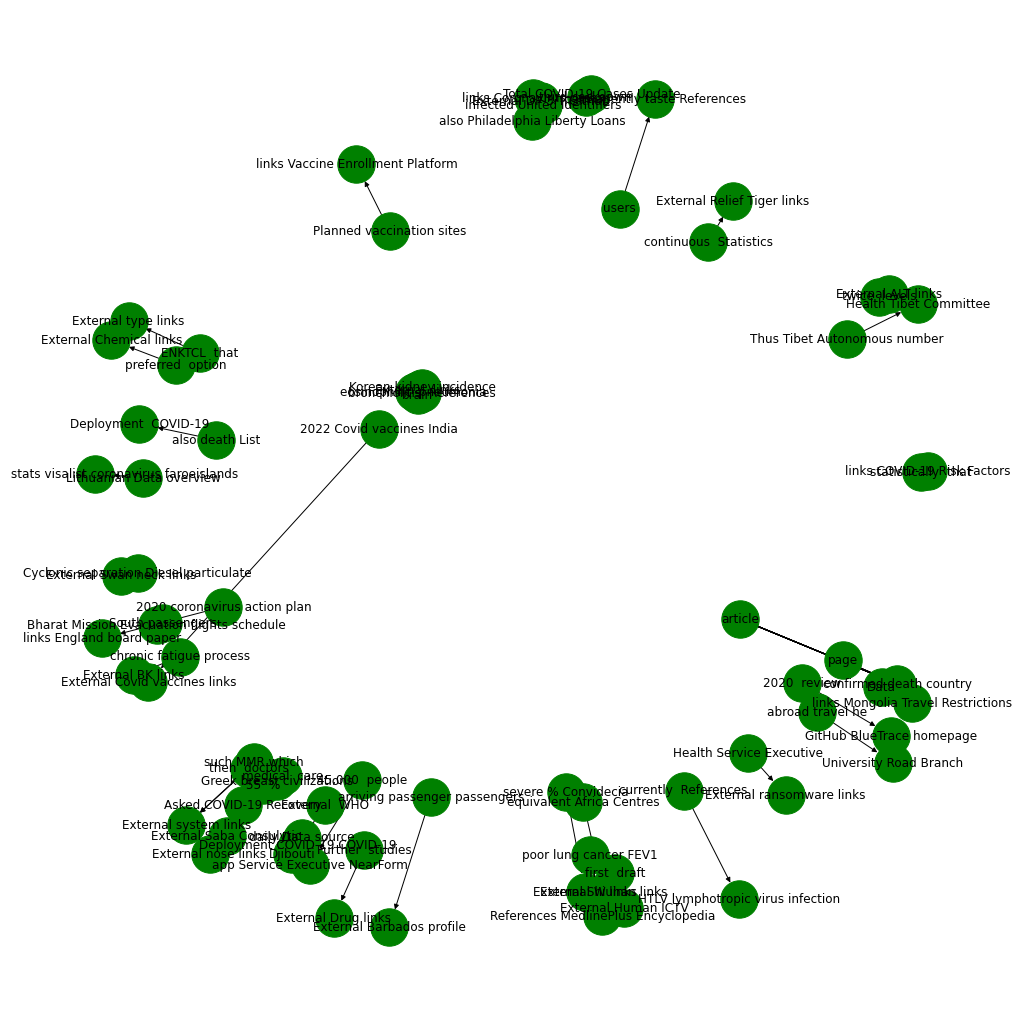

In [28]:
graph = ntx.from_pandas_edgelist(data_kgf[data_kgf['edge']=="External"], "source", "target",
                         edge_attr=True, create_using=ntx.MultiDiGraph())
 
plot.figure(figsize=(14,14))
pos = ntx.spring_layout(graph, k = 0.5) # k regulates the distance between nodes
ntx.draw(graph, with_labels=True, node_color='green', node_size=1400, edge_cmap=plot.cm.Blues, pos = posn)
plot.show()